In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import math

https://medium.com/@pennQuin/implementation-of-long-short-term-memory-lstm-81e35fa5ca54

In [59]:
from IPython.display import clear_output
import warnings

In [60]:
# download dataset from
# https://www.kaggle.com/api/v1/datasets/download/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

import os
import subprocess
import zipfile
import shutil

# Criar diretório data se não existir
if not os.path.exists('data'):
    os.makedirs('data')
    print("Pasta 'data/' criada.")

# URL do dataset
url = "https://www.kaggle.com/api/v1/datasets/download/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews"

# Nome do arquivo zip
zip_file = "archive.zip"

try:
    # Baixar o arquivo usando wget
    print("Baixando o dataset...")
    wget_command = f"wget {url} -O {zip_file}"
    subprocess.run(wget_command, shell=True, check=True)
    print("Download concluído!")
    
    # Descompactar o arquivo
    if os.path.exists(zip_file):
        print(f"Descompactando {zip_file}...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall('temp_imdb')
        
        # Mover o CSV para a pasta data/
        for file in os.listdir('temp_imdb'):
            if file.endswith('.csv'):
                src = os.path.join('temp_imdb', file)
                dst = os.path.join('data', file)
                shutil.move(src, dst)
                print(f"Arquivo {file} movido para data/")
        
        # Limpar arquivos temporários
        shutil.rmtree('temp_imdb')
        os.remove(zip_file)
        print("Arquivos temporários removidos.")
        
        clear_output(wait=True)
        print("'IMDB Dataset.csv' salvo com sucesso em data/")
    else:
        print(f"Erro: Arquivo {zip_file} não foi baixado corretamente.")
        
except subprocess.CalledProcessError as e:
    print(f"Erro ao baixar o arquivo: {e}")
except Exception as e:
    print(f"Erro durante o processamento: {e}")

'IMDB Dataset.csv' salvo com sucesso em data/


In [61]:
df = pd.read_csv('data/IMDB Dataset.csv')
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [62]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [64]:
import re

def remove_html_tags(text):
    """
    Remove HTML tags from a string.
    """
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def remove_special_characters(text):
    """
    Remove special characters from a string.
    """
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

def remove_extra_spaces(text):
    """
    Remove extra spaces from a string.
    """
    return re.sub(r'\s+', ' ', text).strip()
def to_lowercase(text):
    """
    Convert a string to lowercase.
    """
    return text.lower()
def preprocess_text(text):
    """
    Preprocess the input text by removing HTML tags, special characters,
    extra spaces, and converting to lowercase.
    """
    text = remove_html_tags(text)
    text = remove_special_characters(text)
    text = remove_extra_spaces(text)
    text = to_lowercase(text)
    return text

df['clean_review'] = df['review'].apply(preprocess_text)
df['clean_review'].iloc[0]

'one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pretty pictur

In [65]:
# split into 25k train and 25k test
train = df[:25000]
test = df[25000:]

In [66]:
# reduce dataset to 2,5k train and 2,5k test
train = train[:2500]
test = test[:2500]

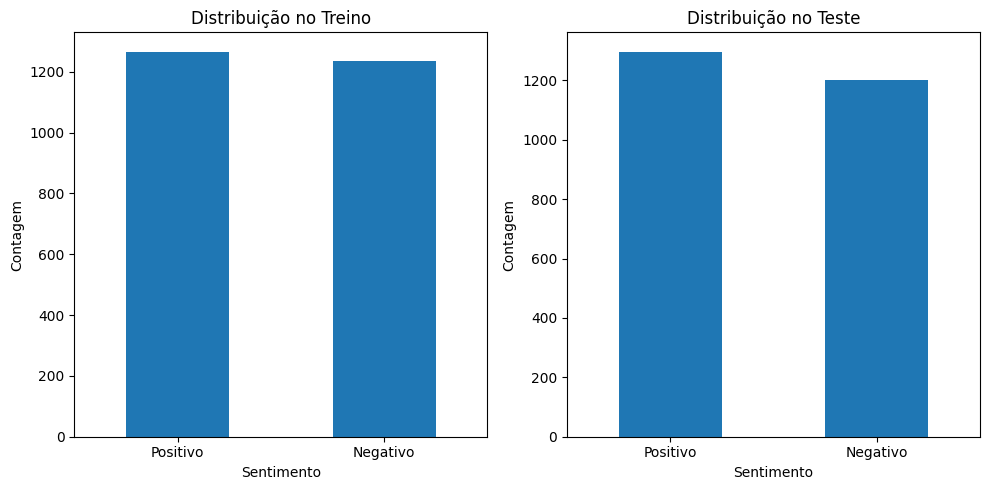

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# check distribution 
train['sentiment'].value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_title('Distribuição no Treino')
ax[0].set_xlabel('Sentimento')
ax[0].set_ylabel('Contagem')
ax[0].set_xticklabels(['Positivo', 'Negativo'], rotation=0)

test['sentiment'].value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_title('Distribuição no Teste')
ax[1].set_xlabel('Sentimento')
ax[1].set_ylabel('Contagem')
ax[1].set_xticklabels(['Positivo', 'Negativo'], rotation=0)
plt.tight_layout()
plt.show()

In [68]:
for i in range(5):
    print('Texto:', train['clean_review'].values[i])
    print('Sentimento:', train['sentiment'].values[i])
    print('---')

Texto: one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pretty 

In [69]:
from keras_hub.tokenizers import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

https://javilopezcastillo.medium.com/sentiment-analysis-using-lstm-networks-a-deep-dive-into-textual-data-61cdd2e43dec

In [70]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

VOCAB_SIZE = 10000

tokenizer = Tokenizer(num_words=VOCAB_SIZE)

tokenizer.fit_on_texts(train['clean_review'])

# Convert the text to sequences
train_sequences = tokenizer.texts_to_sequences(train['clean_review'])
test_sequences = tokenizer.texts_to_sequences(test['clean_review'])
# Pad the sequences
MAX_LENGTH = 100

train_sequences = pad_sequences(train_sequences, maxlen=MAX_LENGTH)
test_sequences = pad_sequences(test_sequences, maxlen=MAX_LENGTH)

# Convert the labels to binary
train_labels = np.where(train['sentiment'] == 'positive', 1, 0)
test_labels = np.where(test['sentiment'] == 'positive', 1, 0)

# Convert the labels to categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [71]:
train_sequences

array([[  10,  120,  199, ...,  109, 4790,  556],
       [3104,   99,   20, ..., 2365,   72,  211],
       [   8,    6,   21, ...,   59,   14,  381],
       ...,
       [   1, 1473, 5017, ..., 3612,  130,  265],
       [  52,   26,  113, ...,  450,    4,  537],
       [ 542,    3,    1, ...,   11,  220,  111]], dtype=int32)

In [72]:
from keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Bidirectional
from keras import regularizers
from keras.optimizers import Adam

model = Sequential()

model.add(Embedding(
    input_dim=tokenizer.num_words,
    output_dim=100,
    input_length=MAX_LENGTH
))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(
    64, activation='relu',
    kernel_regularizer=regularizers.l2(0.01),
    activity_regularizer=regularizers.l1(0.01)
))
model.add(Dense(2, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/home/erlo/.localvenv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [73]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

history = model.fit(
    train_sequences,
    train_labels,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 419ms/step - accuracy: 0.4769 - loss: 1.1987 - val_accuracy: 0.5220 - val_loss: 0.7825
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 359ms/step - accuracy: 0.5051 - loss: 0.7567 - val_accuracy: 0.5220 - val_loss: 0.7170
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - accuracy: 0.5048 - loss: 0.7117 - val_accuracy: 0.5220 - val_loss: 0.6988
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - accuracy: 0.4956 - loss: 0.6976 - val_accuracy: 0.5220 - val_loss: 0.6942
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 394ms/step - accuracy: 0.4945 - loss: 0.6946 - val_accuracy: 0.5220 - val_loss: 0.6935
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 377ms/step - accuracy: 0.4954 - loss: 0.6936 - val_accuracy: 0.5220 - val_loss: 0.6931
Epoch 7/100
 1/16 ━━━━━━━━━━━━━━━━━━━━ 5s 388ms/step - accuracy: 0.4922 - loss: 0.6933

KeyboardInterrupt: 